# Avance 4. Modelos alternativos

## Proyecto Integrador - MNA

### Equipo 21

Integrantes del equipo:
- Guadalupe Esmeralda González Maldonado - A01795767
- Marco Daniel Cameros Bobadilla - A01795655
- Jesús Armando Anaya Orozco - A01795464

Nombre del dataset: DDR2019

## Contexto y objetivo de este notebook

...


## 1) Setup del proyecto y dependencias

Esta sección define entorno, rutas y librerías para asegurar reproducibilidad. Es muy importante que la ejecución sea consistente entre corridas para comparar resultados de forma justa.


Se agregan algunas instrucciones para ejecutar en el servidor de entrenamiento. Para entrenamiento local no son necesarias.

In [1]:
# !pip install -U pip
# !pip install deepspeed>=0.14.0 pydantic==2.0.0 pydantic_settings
# !pip install -U scikit-learn xgboost

In [2]:
from pathlib import Path
import os
import random
from collections import Counter

# Resolver la raíz del proyecto de forma robusta.
# root project in local (../)
PROJECT_ROOT = Path("/home/anaya/Development/Robomous/sam-ai")

# root project in paperspace (/notebooks/sam-ai)
#PROJECT_ROOT = Path("/notebooks/sam-ai")

os.chdir(PROJECT_ROOT)

In [3]:
! pwd

/home/anaya/Development/Robomous/sam-ai


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
import torch.nn as nn
from scipy.stats import randint, uniform
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import DenseNet121_Weights, EfficientNet_B4_Weights
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sam_ml.datasets import DDR2019Dataset
from sam_ml.preprocessing.filters import apply_clahe_bgr

In [5]:
# Fijar semillas para reproducibilidad.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Dataset base para la baseline (baseline).
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "ddr2019_380"
LABELS_CSV = DATA_DIR / "labels.csv"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR (baseline): {DATA_DIR}")
print(f"labels.csv existe: {LABELS_CSV.exists()}")


PROJECT_ROOT: /home/anaya/Development/Robomous/sam-ai
DATA_DIR (baseline): /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019_380
labels.csv existe: True


In [6]:
# Cargar dataset base (una sola imagen por muestra) y validar contrato de salida.
base_dataset_train = DDR2019Dataset(
    data_dir=DATA_DIR,
    split="train",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=transforms.ToTensor(),
    random_state=SEED,
)

base_dataset_all = DDR2019Dataset(
    data_dir=DATA_DIR,
    split="all",
    transform=transforms.ToTensor(),
    random_state=SEED,
)

image_sample, label_sample = base_dataset_train[0]

print(f"Muestras train: {len(base_dataset_train)}")
print(f"Muestras all: {len(base_dataset_all)}")
print(f"Shape imagen: {tuple(image_sample.shape)}")
print(f"Label de ejemplo: {label_sample}")


Muestras train: 9389
Muestras all: 12522
Shape imagen: (3, 380, 380)
Label de ejemplo: 0


## 2) Configuración de preprocesamiento para el baseline

Se usa la normalización esperada por el modelo preentrenado para reducir desajustes entre la distribución de entrada y los pesos aprendidos en ImageNet.

En términos simples, el "input size esperado" es el tamaño de imagen para el que la red fue entrenada originalmente. Mantener ese tamaño y esa normalización ayuda a sostener un comportamiento estable.


In [7]:
# Definir pesos de referencia para el baseline.
densenet_weights = DenseNet121_Weights.DEFAULT
densenet_preset = densenet_weights.transforms()

densenet_norm_mean = torch.tensor(densenet_preset.mean, dtype=torch.float32)
densenet_norm_std = torch.tensor(densenet_preset.std, dtype=torch.float32)

print("Normalización del baseline (DenseNet-121):")
print(f"  input_size esperado: {densenet_preset.crop_size[0]} x {densenet_preset.crop_size[0]}")
print(f"  mean: {densenet_norm_mean.tolist()}")
print(f"  std: {densenet_norm_std.tolist()}")


Normalización del baseline (DenseNet-121):
  input_size esperado: 224 x 224
  mean: [0.48500001430511475, 0.4560000002384186, 0.4059999883174896]
  std: [0.2290000021457672, 0.2240000069141388, 0.22499999403953552]


## 3) Transformaciones de normalización del baseline

Se aplica normalización compatible con DenseNet-121 usando estadísticas de ImageNet.

Estas transformaciones preparan la imagen para que el backbone "vea" los datos en condiciones similares a su preentrenamiento. Eso reduce el riesgo de degradación por cambio de escala o distribución.

In [8]:
def normalize_with_stats_torch(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Normalizar tensor RGB con media/desviación esperadas por un backbone."""
    m = mean.view(3, 1, 1).to(x.device, x.dtype)
    s = std.view(3, 1, 1).to(x.device, x.dtype).clamp_min(1e-8)
    return (x - m) / s


def denormalize_with_stats_torch(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Deshacer normalización RGB para visualización."""
    m = mean.view(3, 1, 1).to(x.device, x.dtype)
    s = std.view(3, 1, 1).to(x.device, x.dtype)
    return x * s + m


def preprocess_image_for_densenet(x: torch.Tensor) -> torch.Tensor:
    """Preprocesar imagen para baseline con DenseNet-121."""
    x = x.float().clamp(0.0, 1.0)
    return normalize_with_stats_torch(x, densenet_norm_mean, densenet_norm_std)


## 4) Balanceo de clases

En retinopatía diabética existe desbalance de clases y esto impacta directamente la calidad del aprendizaje. Si se entrena sin control, el modelo tiende a optimizar para clases frecuentes y puede degradar el recall en clases con menos ejemplos.

### Decisión metodológica usada en este notebook

1. Primero se **fusionan 5 clases en 3** (`0`, `1+2`, `3+4`) para reducir ambigüedad entre severidades adyacentes.
2. Después se construye un **set de entrenamiento balanceado real** (el que entra al modelo), en lugar de reportar distribuciones parciales.
3. Se usa augmentación geométrica controlada (`original + hflip + vflip + 1 rotación`) y downsampling en mayoritarias cuando corresponde.

### Justificación de por qué se hace así

- **Evitar sesgo de frecuencia**: una clase con muchos más ejemplos domina la función objetivo.
- **Evitar sobre-augmentación sin criterio**: aumentar clases de manera desproporcionada puede volver a desbalancear el train.
- **Mantener factibilidad de cómputo**: se usa un objetivo alcanzable con los 4 modos de augmentación disponibles.

Conexión con rúbrica: este bloque justifica por qué **macro-F1** y **macro-recall** son métricas prioritarias. En escenarios desbalanceados, accuracy puede verse alta y aun así ocultar mal desempeño en clases menos frecuentes.

**Costo/beneficio**: balancear mejora cobertura por clase y estabilidad del entrenamiento, pero incrementa costo de cómputo por el número de muestras transformadas.

In [9]:
train_rows = base_dataset_train._rows.reset_index(drop=True).copy()

class_counts = train_rows["label"].value_counts().sort_index()
mean_count = class_counts.mean()
minority_threshold = mean_count * 0.5
minority_classes = set(class_counts[class_counts < minority_threshold].index.tolist())

AUGMENTATION_MULTIPLIER = 4
MAJORITY_CAP = 3500

augmentation_targets: dict[int, dict[str, float]] = {}
for label, count in class_counts.items():
    is_minority = int(label) in minority_classes
    target_count = int(count) * AUGMENTATION_MULTIPLIER if is_minority else int(count)
    augmentation_targets[int(label)] = {
        "current_count": int(count),
        "target_count": int(target_count),
        "multiplier": AUGMENTATION_MULTIPLIER if is_minority else 1,
        "is_minority": is_minority,
    }

downsampling_ratios: dict[int, dict[str, float]] = {}
for label, count in class_counts.items():
    is_majority = float(count) > float(mean_count)
    if is_majority and int(count) > MAJORITY_CAP:
        new_count = MAJORITY_CAP
        reduction_pct = (1.0 - (new_count / int(count))) * 100.0
    else:
        new_count = int(count)
        reduction_pct = 0.0
    downsampling_ratios[int(label)] = {
        "current_count": int(count),
        "new_count": int(new_count),
        "reduction_pct": float(reduction_pct),
        "is_downsampled": bool(is_majority and int(count) > MAJORITY_CAP),
    }

final_counts: dict[int, int] = {}
for label in sorted(class_counts.index.tolist()):
    if int(label) in minority_classes:
        final_counts[int(label)] = int(augmentation_targets[int(label)]["target_count"])
    else:
        final_counts[int(label)] = int(downsampling_ratios[int(label)]["new_count"])

original_imbalance_ratio = float(class_counts.max() / class_counts.min())
final_counts_series = pd.Series(final_counts).sort_index()
final_imbalance_ratio = float(final_counts_series.max() / final_counts_series.min())

print("Resumen de balanceo (baseline):")
print(f"  class_counts: {class_counts.to_dict()}")
print(f"  mean_count: {mean_count:.2f}")
print(f"  minority_threshold (50% mean): {minority_threshold:.2f}")
print(f"  minority_classes: {sorted(list(minority_classes))}")
print(f"  AUGMENTATION_MULTIPLIER: {AUGMENTATION_MULTIPLIER}")
print(f"  MAJORITY_CAP: {MAJORITY_CAP}")
print(f"  ratio original: {original_imbalance_ratio:.2f}:1")
print(f"  ratio final: {final_imbalance_ratio:.2f}:1")


Resumen de balanceo (baseline):
  class_counts: {0: 4699, 1: 472, 2: 3357, 3: 177, 4: 684}
  mean_count: 1877.80
  minority_threshold (50% mean): 938.90
  minority_classes: [1, 3, 4]
  AUGMENTATION_MULTIPLIER: 4
  MAJORITY_CAP: 3500
  ratio original: 26.55:1
  ratio final: 4.94:1


## 5) Utilidades de balanceo y augmentación

Estas utilidades concentran la lógica de muestreo por clase y de augmentación geométrica reproducible.

La idea es mantener reglas consistentes de balanceo para aumentar exposición de clases minoritarias y reducir dominancia de clases mayoritarias, sin alterar el flujo principal del baseline.


In [10]:
def _sample_indices_per_class(
    rows: pd.DataFrame,
    majority_cap: int,
    seed: int,
) -> list[int]:
    """Aplicar downsampling por clase para mayoritarias y mantener el resto."""
    rng = np.random.default_rng(seed)
    selected: list[int] = []

    counts = rows["label"].value_counts().sort_index()
    mean_count_local = counts.mean()

    for label in sorted(counts.index.tolist()):
        cls_rows = rows[rows["label"] == label]
        cls_indices = cls_rows.index.to_numpy()
        is_majority = counts[label] > mean_count_local

        if is_majority and len(cls_indices) > majority_cap:
            chosen = rng.choice(cls_indices, size=majority_cap, replace=False)
            selected.extend(chosen.tolist())
        else:
            selected.extend(cls_indices.tolist())

    return selected


def _build_augmented_sample_list(
    rows: pd.DataFrame,
    selected_indices: list[int],
    minority_set: set[int],
) -> list[tuple[int, int]]:
    """Construir lista (base_index, aug_id) según clase minoritaria/no minoritaria."""
    samples: list[tuple[int, int]] = []
    for idx in selected_indices:
        label = int(rows.loc[idx, "label"])
        if label in minority_set:
            # 0 = original, 1 = hflip, 2 = vflip, 3 = rot
            for aug_id in (0, 1, 2, 3):
                samples.append((int(idx), int(aug_id)))
        else:
            samples.append((int(idx), 0))
    return samples


def _draw_rotation_angles(rng: np.random.Generator) -> tuple[float, float]:
    """Generar dos ángulos distintos con magnitud en [10,15]."""

    def _one_angle() -> float:
        mag = float(rng.uniform(10.0, 15.0))
        sign = -1.0 if rng.random() < 0.5 else 1.0
        return sign * mag

    angle1 = _one_angle()
    angle2 = _one_angle()
    while abs(angle2 - angle1) < 1e-6:
        angle2 = _one_angle()
    return angle1, angle2



## 6) Verificación inicial del pipeline

Este bloque valida integridad básica del flujo antes de entrenar:

- formato y dimensiones esperadas de tensores,
- etiquetas en rango válido,
- consistencia entre tamaño del batch y contenido.

Esta verificación es muy importante para detectar errores tempranos de datos y evitar diagnósticos confusos durante el entrenamiento.


In [11]:
# Verificación rápida del dataset base (baseline).
batch_size = 8
baseline_loader = DataLoader(
    base_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

images_batch, labels_batch = next(iter(baseline_loader))

print("Sanity check:")
print(f"  images_batch shape: {tuple(images_batch.shape)}")
print(f"  labels_batch shape: {tuple(labels_batch.shape)}")
print(f"  rango imágenes: [{float(images_batch.min()):.3f}, {float(images_batch.max()):.3f}]")


Sanity check:
  images_batch shape: (8, 3, 380, 380)
  labels_batch shape: (8,)
  rango imágenes: [0.000, 1.000]


=== Resumen de pipeline ===
DATA_DIR: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019_380
Split train base: 9389
Split all base: 12522
images_batch shape: (8, 3, 380, 380)
labels_batch shape: (8,)
Distribución original (train): {0: 4699, 1: 472, 2: 3357, 3: 177, 4: 684}
Distribución final objetivo: {0: 3500, 1: 1888, 2: 3357, 3: 708, 4: 2736}
Ratio original: 26.55:1
Ratio final: 4.94:1


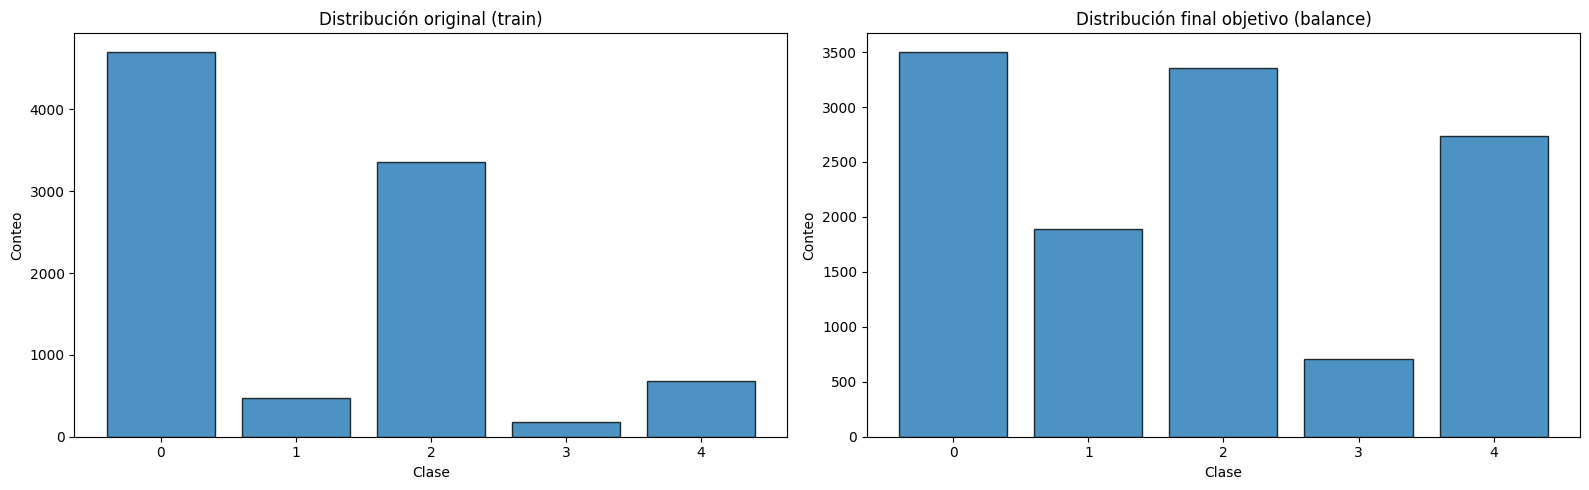

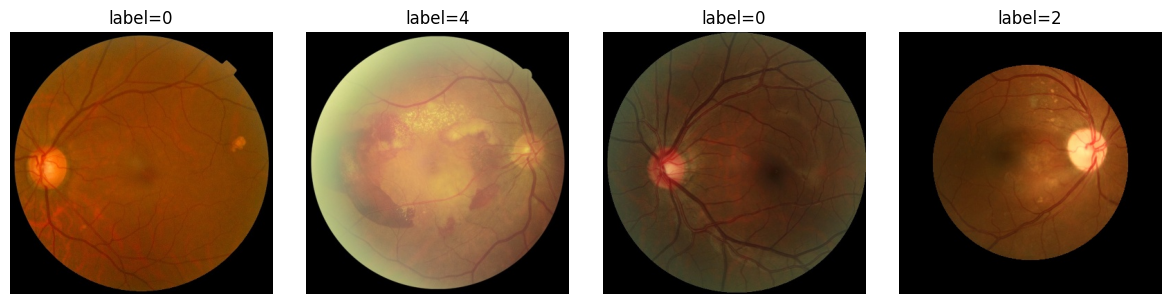

In [12]:
print("=== Resumen de pipeline ===")
print(f"DATA_DIR: {DATA_DIR}")
print(f"Split train base: {len(base_dataset_train)}")
print(f"Split all base: {len(base_dataset_all)}")
print(f"images_batch shape: {tuple(images_batch.shape)}")
print(f"labels_batch shape: {tuple(labels_batch.shape)}")
print(f"Distribución original (train): {class_counts.to_dict()}")
print(f"Distribución final objetivo: {final_counts_series.to_dict()}")
print(f"Ratio original: {original_imbalance_ratio:.2f}:1")
print(f"Ratio final: {final_imbalance_ratio:.2f}:1")

# Graficar distribución original vs final objetivo.
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

classes_sorted = sorted(class_counts.index.tolist())
x = np.arange(len(classes_sorted))
orig_values = [int(class_counts.loc[c]) for c in classes_sorted]
final_values = [int(final_counts_series.loc[c]) for c in classes_sorted]

axes[0].bar(x, orig_values, edgecolor="black", alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes_sorted)
axes[0].set_title("Distribución original (train)")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Conteo")

axes[1].bar(x, final_values, edgecolor="black", alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes_sorted)
axes[1].set_title("Distribución final objetivo (balance)")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("Conteo")

plt.tight_layout()
plt.show()

# Mostrar muestras del batch de la baseline.
n_show = min(4, images_batch.shape[0])
fig, axes = plt.subplots(1, n_show, figsize=(3 * n_show, 3))
if n_show == 1:
    axes = np.array([axes])

for i in range(n_show):
    image_vis = images_batch[i].detach().cpu().clamp(0.0, 1.0)
    axes[i].imshow(np.transpose(image_vis.numpy(), (1, 2, 0)))
    axes[i].set_title(f"label={int(labels_batch[i])}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Después de aplicar aumento de datos en las cinco clases, observamos que algunas categorías siguen quedando muy desbalanceadas. Intentamos entrenar el modelo respetando esas proporciones, pero los resultados no fueron favorables. Por ello, decidimos aplicar un ajuste adicional de ingeniería de características: combinar las clases 1 y 2, y también las clases 3 y 4. Esto, derivado de la naturaleza de las clases y considerando lo que consideramos, podría impactar de forma menos negativa a los resultados.

## 7) Baseline (DenseNet-121 + XGBoost)

### ¿Por qué usamos este baseline?
Porque es una forma práctica de clasificar imágenes con costo de cómputo controlado y resultados reproducibles:

- **DenseNet-121 (preentrenado)** se usa para convertir cada imagen en un vector de números que resume su contenido visual.
- **XGBoost** toma ese vector y aprende a predecir la clase. Además, es rápido de entrenar y permite revisar qué señales influyen más.

### Desempeño mínimo esperado
El modelo debe superar un punto de referencia muy simple, predecir siempre la clase mayoritaria.

Si no lo supera, lo más probable es que el problema esté en la señal de los datos o en el flujo de preprocesamiento, y conviene ajustar eso antes de hacer el modelo más complejo.


### Ajuste metodológico previo al feature engineering

Antes de extraer características se realizan ajustes deliberados al conjunto de datos para que el entrenamiento sea más estable, más fácil de interpretar y mejor alineado al riesgo clínico.

- Reducción de 5 a 3 clases: se agrupan etiquetas cercanas (`0, 1+2, 3+4`) para disminuir ambigüedad entre grados adyacentes y reducir ruido en las fronteras de decisión.
- Criterio clínico explícito: en este contexto conviene minimizar falsos negativos en casos de mayor severidad; por eso, cuando hay duda, se prefiere un sesgo conservador hacia categorías de mayor riesgo.
- Balanceo con objetivo verificable: se define un `target_count_per_class` realista y se valida con los conteos finales mostrados (`final_train_counts` y `final_train_proportions`).
- Augmentación controlada: se aplican transformaciones geométricas simples (`hflip`, `vflip`, `rotación`) para mejorar robustez sin modificar la semántica clínica de la imagen.
- CLAHE consistente en `train/val`: se aplica el mismo criterio de preprocesamiento en entrenamiento y validación para evitar cambios de distribución.

Muy importante: la distribución mostrada en esta sección corresponde al dataset final que entra al modelo, no a una etapa intermedia.

In [13]:
def _imagenet_stats_from_weights(weights_enum: object) -> tuple[list[float], list[float]]:
    weights = weights_enum.DEFAULT
    mean = list(weights.meta.get("mean", (0.485, 0.456, 0.406)))
    std = list(weights.meta.get("std", (0.229, 0.224, 0.225)))
    return mean, std


def _input_size_from_weights(weights_enum: object, default: int = 224) -> int:
    weights = weights_enum.DEFAULT
    crop_size = getattr(weights.transforms(), "crop_size", None)
    if crop_size is None:
        return int(default)

    if isinstance(crop_size, (tuple, list)):
        if len(crop_size) == 0:
            return int(default)
        return int(crop_size[0])

    return int(crop_size)


def _imagenet_stats_from_densenet() -> tuple[list[float], list[float]]:
    return _imagenet_stats_from_weights(DenseNet121_Weights)


def _imagenet_stats_from_efficientnet_b4() -> tuple[list[float], list[float]]:
    return _imagenet_stats_from_weights(EfficientNet_B4_Weights)


def _to_gray(x: torch.Tensor) -> torch.Tensor:
    """Convertir RGB->grayscale (tensor CHW en [0,1])."""
    r, g, b = x[0], x[1], x[2]
    return (0.2989 * r + 0.5870 * g + 0.1140 * b).clamp(0.0, 1.0)


def _global_features(x: torch.Tensor, hist_bins: int = 16) -> torch.Tensor:
    """Features globales: mean/std por canal + histograma en escala de grises."""
    ch_mean = x.mean(dim=(1, 2))
    ch_std = x.std(dim=(1, 2), unbiased=False)

    gray = _to_gray(x)
    hist = torch.histc(gray, bins=int(hist_bins), min=0.0, max=1.0)
    hist = hist / (hist.sum().clamp_min(1.0))

    return torch.cat([ch_mean, ch_std, hist], dim=0).float()


def _apply_geometry(
    image: torch.Tensor,
    aug_id: int,
    idx: int,
    seed: int,
) -> torch.Tensor:
    """Aplicar augmentación geométrica simple (reproducible por índice)."""
    if int(aug_id) == 0:
        return image
    if int(aug_id) == 1:
        return TF.hflip(image)
    if int(aug_id) == 2:
        return TF.vflip(image)

    rng = np.random.default_rng(int(seed) + int(idx))
    mag = float(rng.uniform(10.0, 15.0))
    sign = -1.0 if rng.random() < 0.5 else 1.0
    angle = sign * mag

    return TF.rotate(
        image,
        angle=float(angle),
        interpolation=InterpolationMode.BILINEAR,
        fill=0.0,
    )


LABEL_MAP_5_TO_3: dict[int, int] = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}


class MappedLabelDataset(Dataset):
    """Wrap a base dataset and remap labels while preserving _rows support."""

    def __init__(self, base_dataset: DDR2019Dataset, label_map: dict[int, int]) -> None:
        self.base_dataset = base_dataset
        self.label_map = dict(label_map)
        self._rows = self.base_dataset._rows.copy()
        self._rows["label"] = self._rows["label"].map(self.label_map).astype(int)

    def __len__(self) -> int:
        return len(self.base_dataset)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        image, label = self.base_dataset[int(idx)]
        return image, int(self.label_map[int(label)])


class ClahePILTransform:
    """Apply CLAHE in BGR space and return a PIL RGB image."""

    def __call__(self, image: Image.Image) -> Image.Image:
        rgb = np.asarray(image.convert("RGB"), dtype=np.uint8)
        bgr = np.ascontiguousarray(rgb[..., ::-1])
        bgr_clahe = apply_clahe_bgr(bgr)
        rgb_clahe = np.ascontiguousarray(bgr_clahe[..., ::-1])
        return Image.fromarray(rgb_clahe)


class BaselineSingleFeatureDataset(Dataset):
    """Dataset baseline: imagen para backbone + features globales extra."""

    def __init__(
        self,
        base_dataset: "DDR2019Dataset",
        samples: list[tuple[int, int]],
        seed: int,
        image_size: int = 224,
        hist_bins: int = 16,
        mean: list[float] | None = None,
        std: list[float] | None = None,
    ) -> None:
        self.base_dataset = base_dataset
        self.samples = list(samples)
        self.seed = int(seed)
        self.image_size = int(image_size)
        self.hist_bins = int(hist_bins)

        densenet_mean, densenet_std = _imagenet_stats_from_densenet()
        self.mean = list(densenet_mean if mean is None else mean)
        self.std = list(densenet_std if std is None else std)

    def __len__(self) -> int:
        return len(self.samples)

    def _prep_for_backbone(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        x = TF.resize(
            x,
            [self.image_size, self.image_size],
            interpolation=InterpolationMode.BILINEAR,
            antialias=True,
        )
        x = x.float().clamp(0.0, 1.0)

        extra = _global_features(x, hist_bins=self.hist_bins)
        x_norm = TF.normalize(x, mean=self.mean, std=self.std)
        return x_norm, extra

    def __getitem__(self, item_idx: int) -> dict[str, torch.Tensor]:
        base_index, aug_id = self.samples[int(item_idx)]
        image, label = self.base_dataset[int(base_index)]
        image = image.float().clamp(0.0, 1.0)

        image_aug = _apply_geometry(
            image,
            aug_id=int(aug_id),
            idx=int(base_index),
            seed=self.seed,
        )

        image_in, extra = self._prep_for_backbone(image_aug)

        return {
            "image": image_in,
            "extra": extra,
            "label": torch.tensor(int(label), dtype=torch.long),
        }


# DenseNet-121 como extractor de características.
def build_densenet121_feature_extractor() -> nn.Module:
    """DenseNet-121 preentrenado como extractor: salida (B, 1024)."""
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Identity()

    for p in model.parameters():
        p.requires_grad = False

    return model


def build_efficientnet_b4_feature_extractor() -> nn.Module:
    """EfficientNet-B4 preentrenado como extractor: salida (B, 1792)."""
    model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
    model.classifier = nn.Identity()

    for p in model.parameters():
        p.requires_grad = False

    return model


def _forward_backbone_features(feature_model: nn.Module, image: torch.Tensor) -> torch.Tensor:
    out = feature_model(image)
    if isinstance(out, torch.Tensor):
        return out
    if isinstance(out, (tuple, list)):
        out0 = out[0]
        if not isinstance(out0, torch.Tensor):
            raise TypeError("Backbone output tuple/list does not contain tensor features.")
        return out0
    if isinstance(out, dict):
        for key in ("features", "logits", "out"):
            if key in out and isinstance(out[key], torch.Tensor):
                return out[key]
    raise TypeError(f"Unsupported backbone output type: {type(out)}")


@torch.no_grad()
def extract_backbone_features(
    feature_model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    desc: str,
) -> tuple[np.ndarray, np.ndarray]:
    """Extraer features concatenadas (backbone + extras)."""
    feature_model = feature_model.to(device)
    feature_model.eval()

    feats: list[np.ndarray] = []
    labels: list[np.ndarray] = []

    for batch in tqdm(loader, desc=desc, total=len(loader)):
        image = batch["image"].to(device, non_blocking=True)
        extra = batch["extra"].to(device, non_blocking=True)
        y = batch["label"].detach().cpu().numpy()

        f = _forward_backbone_features(feature_model, image)
        f = torch.cat([f, extra], dim=1)

        feats.append(f.detach().cpu().numpy())
        labels.append(y)

    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labels, axis=0)

    print("Feature matrix shape:", X.shape)
    return X, y


In [14]:
# 1) Cargar dataset simple con CLAHE consistente en todos los splits.
DATA_DIR_BASELINE = DATA_DIR

clahe_to_tensor = transforms.Compose([
    ClahePILTransform(),
    transforms.ToTensor(),
])

baseline_train_ds_raw = DDR2019Dataset(
    data_dir=DATA_DIR_BASELINE,
    split="train",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=clahe_to_tensor,
    random_state=SEED,
)
baseline_val_ds_raw = DDR2019Dataset(
    data_dir=DATA_DIR_BASELINE,
    split="val",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=clahe_to_tensor,
    random_state=SEED,
)

baseline_train_ds = MappedLabelDataset(baseline_train_ds_raw, LABEL_MAP_5_TO_3)
baseline_val_ds = MappedLabelDataset(baseline_val_ds_raw, LABEL_MAP_5_TO_3)

print("Dataset baseline - data decisions")
print(f"  DATA_DIR_BASELINE: {DATA_DIR_BASELINE}")
print(f"  train samples: {len(baseline_train_ds)}")
print(f"  val samples  : {len(baseline_val_ds)}")
print(f"  label mapping used (5->3): {LABEL_MAP_5_TO_3}")
print(f"  labels present in train after mapping: {sorted(baseline_train_ds._rows['label'].unique().tolist())}")
print("  preprocessing consistency: CLAHE is applied to both train and val")

Dataset baseline - data decisions
  DATA_DIR_BASELINE: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019_380
  train samples: 9389
  val samples  : 3133
  label mapping used (5->3): {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}
  labels present in train after mapping: [0, 1, 2]
  preprocessing consistency: CLAHE is applied to both train and val


In [15]:
# 2) Strategy requested: merge 1+2 -> class 1, merge 3+4 -> class 2.
# Train sampling policy:
# - class 0: keep as-is (no augmentation)
# - class 1: keep as-is, but shuffle examples
# - class 2: apply x4 augmentation (original + 3 geometric variants)
# Validation: merged labels only, no augmentation.
train_rows_baseline = baseline_train_ds._rows.reset_index(drop=True).copy()
class_counts_baseline = train_rows_baseline["label"].value_counts().sort_index()

CLASS2_AUGMENTATION_MODES = [0, 1, 2, 3]
rng = np.random.default_rng(SEED)
train_samples: list[tuple[int, int]] = []

for class_id in sorted(int(x) for x in class_counts_baseline.index.tolist()):
    class_indices = train_rows_baseline[train_rows_baseline["label"] == class_id].index.to_numpy()

    # Shuffle class 1 examples explicitly as requested.
    if class_id == 1:
        class_indices = rng.permutation(class_indices)

    if class_id == 2:
        # x4 only for merged severe class (new class 2).
        for aug_id in CLASS2_AUGMENTATION_MODES:
            train_samples.extend((int(idx), int(aug_id)) for idx in class_indices.tolist())
    else:
        # class 0 and class 1: original only.
        train_samples.extend((int(idx), 0) for idx in class_indices.tolist())

# Final distribution actually used for model training.
train_counts_after_aug = (
    pd.Series([int(train_rows_baseline.loc[int(idx), "label"]) for idx, _ in train_samples])
    .value_counts()
    .sort_index()
)
train_proportions_after_aug = (train_counts_after_aug / train_counts_after_aug.sum()).sort_index()

print("Training-set augmentation summary (requested strategy):")
print(f"  merged class_counts (raw train split): {class_counts_baseline.to_dict()}")
print("  class 0 policy: original only")
print("  class 1 policy: original only + shuffled order")
print(f"  class 2 policy: x4 with modes {CLASS2_AUGMENTATION_MODES}")
print(f"  final_train_counts used by model: {train_counts_after_aug.to_dict()}")
print(
    "  final_train_proportions used by model (%): "
    + str({int(k): round(float(v) * 100.0, 2) for k, v in train_proportions_after_aug.items()})
)

# Validation keeps natural distribution (merged labels, no augmentation).
val_samples = [(int(i), 0) for i in range(len(baseline_val_ds))]

# Quick sanity checks.
print("Sanity checks:")
print(f"  train_samples: {len(train_samples)}")
print(f"  val_samples  : {len(val_samples)}")
print(f"  labels in train rows: {sorted(class_counts_baseline.index.astype(int).tolist())}")

check_idx = int(train_rows_baseline[train_rows_baseline["label"] == 2].index[0])
img_base, _ = baseline_train_ds[check_idx]
img_rot = _apply_geometry(img_base, aug_id=3, idx=check_idx, seed=SEED)
print(f"  augmentation changed sample (class 2, rotation): {bool(not torch.allclose(img_base, img_rot))}")

Training-set augmentation summary (requested strategy):
  merged class_counts (raw train split): {0: 4699, 1: 3829, 2: 861}
  class 0 policy: original only
  class 1 policy: original only + shuffled order
  class 2 policy: x4 with modes [0, 1, 2, 3]
  final_train_counts used by model: {0: 4699, 1: 3829, 2: 3444}
  final_train_proportions used by model (%): {0: 39.25, 1: 31.98, 2: 28.77}
Sanity checks:
  train_samples: 11972
  val_samples  : 3133
  labels in train rows: [0, 1, 2]
  augmentation changed sample (class 2, rotation): True


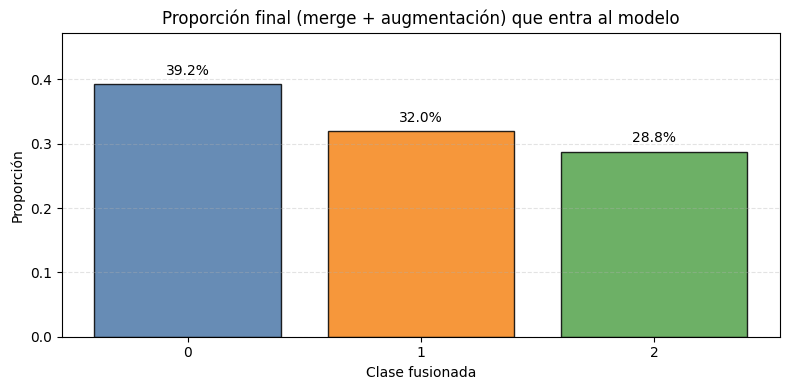

In [16]:
# Distribución final que entra al modelo
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(
    train_proportions_after_aug.index.astype(str),
    train_proportions_after_aug.values,
    color=["#4C78A8", "#F58518", "#54A24B"],
    edgecolor="black",
    alpha=0.85,
)

for bar, prop in zip(bars, train_proportions_after_aug.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{prop * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

ax.set_title("Proporción final (merge + augmentación) que entra al modelo")
ax.set_xlabel("Clase fusionada")
ax.set_ylabel("Proporción")
ax.set_ylim(0, min(1.0, float(train_proportions_after_aug.max()) + 0.08))
ax.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()

In [17]:
# 2b) Active strategy: keep class 0 as-is, merge 1+2->1, merge 3+4->2,
# and augment only class 2 in TRAIN with x4 (original + 3 geometric variants).
# This cell overrides train_samples/val_samples from previous strategy cells.
train_rows_baseline = baseline_train_ds._rows.reset_index(drop=True).copy()
class_counts_baseline = train_rows_baseline["label"].value_counts().sort_index()

CLASS2_AUGMENTATION_MODES = [0, 1, 2, 3]
rng = np.random.default_rng(SEED)
train_samples: list[tuple[int, int]] = []

for class_id in sorted(int(x) for x in class_counts_baseline.index.tolist()):
    class_indices = train_rows_baseline[train_rows_baseline["label"] == class_id].index.to_numpy()

    # Keep class 1 merged examples, shuffled (no extra augmentation).
    if class_id == 1:
        class_indices = rng.permutation(class_indices)

    if class_id == 2:
        for aug_id in CLASS2_AUGMENTATION_MODES:
            train_samples.extend((int(idx), int(aug_id)) for idx in class_indices.tolist())
    else:
        train_samples.extend((int(idx), 0) for idx in class_indices.tolist())

train_counts_after_aug = (
    pd.Series([int(train_rows_baseline.loc[int(idx), "label"]) for idx, _ in train_samples])
    .value_counts()
    .sort_index()
)
train_proportions_after_aug = (train_counts_after_aug / train_counts_after_aug.sum()).sort_index()

print("Training-set augmentation summary (active strategy):")
print(f"  merged class_counts (raw train split): {class_counts_baseline.to_dict()}")
print("  class 0 policy: original only")
print("  class 1 policy: original only + shuffled order")
print(f"  class 2 policy: x4 with modes {CLASS2_AUGMENTATION_MODES}")
print(f"  final_train_counts used by model: {train_counts_after_aug.to_dict()}")
print(
    "  final_train_proportions used by model (%): "
    + str({int(k): round(float(v) * 100.0, 2) for k, v in train_proportions_after_aug.items()})
)

# Validation keeps merged labels but no augmentation.
val_samples = [(int(i), 0) for i in range(len(baseline_val_ds))]

print("Sanity checks:")
print(f"  train_samples: {len(train_samples)}")
print(f"  val_samples  : {len(val_samples)}")
print(f"  labels in train rows: {sorted(class_counts_baseline.index.astype(int).tolist())}")

check_idx = int(train_rows_baseline[train_rows_baseline["label"] == 2].index[0])
img_base, _ = baseline_train_ds[check_idx]
img_rot = _apply_geometry(img_base, aug_id=3, idx=check_idx, seed=SEED)
print(f"  augmentation changed sample (class 2, rotation): {bool(not torch.allclose(img_base, img_rot))}")

Training-set augmentation summary (active strategy):
  merged class_counts (raw train split): {0: 4699, 1: 3829, 2: 861}
  class 0 policy: original only
  class 1 policy: original only + shuffled order
  class 2 policy: x4 with modes [0, 1, 2, 3]
  final_train_counts used by model: {0: 4699, 1: 3829, 2: 3444}
  final_train_proportions used by model (%): {0: 39.25, 1: 31.98, 2: 28.77}
Sanity checks:
  train_samples: 11972
  val_samples  : 3133
  labels in train rows: [0, 1, 2]
  augmentation changed sample (class 2, rotation): True


In [18]:
# 3) Extraer features para dos backbones consecutivos: DenseNet121 y EfficientNetB4.
FEATURE_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo para extracción de features: {FEATURE_DEVICE}")

if FEATURE_DEVICE.type == "cuda":
    # Recomendado para GPUs con Tensor Cores.
    torch.set_float32_matmul_precision("high")


def _make_loaders_for_backbone(
    image_size: int,
    mean: list[float],
    std: list[float],
    batch_size: int = 32,
) -> tuple[DataLoader, DataLoader]:
    train_fe_ds = BaselineSingleFeatureDataset(
        base_dataset=baseline_train_ds,
        samples=train_samples,
        seed=SEED,
        image_size=int(image_size),
        hist_bins=16,
        mean=mean,
        std=std,
    )
    val_fe_ds = BaselineSingleFeatureDataset(
        base_dataset=baseline_val_ds,
        samples=val_samples,
        seed=SEED,
        image_size=int(image_size),
        hist_bins=16,
        mean=mean,
        std=std,
    )

    num_workers = min(4, os.cpu_count() or 1)
    train_loader_local = DataLoader(
        train_fe_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    val_loader_local = DataLoader(
        val_fe_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    return train_loader_local, val_loader_local


dense_mean, dense_std = _imagenet_stats_from_densenet()
effb4_mean, effb4_std = _imagenet_stats_from_efficientnet_b4()
dense_image_size = 224
effb4_image_size = _input_size_from_weights(EfficientNet_B4_Weights, default=380)

experiment_configs = [
    {
        "name": "DenseNet121",
        "model_builder": build_densenet121_feature_extractor,
        "mean": dense_mean,
        "std": dense_std,
        "image_size": dense_image_size,
        "extract_desc_train": "Extrayendo features (DenseNet121 train)",
        "extract_desc_val": "Extrayendo features (DenseNet121 val)",
    },
    {
        "name": "EfficientNetB4",
        "model_builder": build_efficientnet_b4_feature_extractor,
        "mean": effb4_mean,
        "std": effb4_std,
        "image_size": effb4_image_size,
        "extract_desc_train": "Extrayendo features (EfficientNetB4 train)",
        "extract_desc_val": "Extrayendo features (EfficientNetB4 val)",
    },
]

feature_sets: dict[str, dict[str, np.ndarray]] = {}

for cfg in experiment_configs:
    print("\n" + "=" * 80)
    print(f"Extracción backbone: {cfg['name']}")
    print(f"  image_size: {cfg['image_size']}")
    print(f"  mean: {cfg['mean']}")
    print(f"  std : {cfg['std']}")

    train_loader_local, val_loader_local = _make_loaders_for_backbone(
        image_size=int(cfg["image_size"]),
        mean=list(cfg["mean"]),
        std=list(cfg["std"]),
    )

    feature_model = cfg["model_builder"]()
    X_train_local, y_train_local = extract_backbone_features(
        feature_model,
        train_loader_local,
        FEATURE_DEVICE,
        desc=str(cfg["extract_desc_train"]),
    )
    X_val_local, y_val_local = extract_backbone_features(
        feature_model,
        val_loader_local,
        FEATURE_DEVICE,
        desc=str(cfg["extract_desc_val"]),
    )

    print(f"  Labels train: {sorted(np.unique(y_train_local).tolist())}")
    print(f"  Labels val  : {sorted(np.unique(y_val_local).tolist())}")

    feature_sets[str(cfg["name"])] = {
        "X_train": X_train_local,
        "y_train": y_train_local,
        "X_val": X_val_local,
        "y_val": y_val_local,
    }

# Keep legacy aliases (DenseNet) to preserve notebook compatibility with downstream cells.
X_train = feature_sets["DenseNet121"]["X_train"]
y_train = feature_sets["DenseNet121"]["y_train"]
X_val = feature_sets["DenseNet121"]["X_val"]
y_val = feature_sets["DenseNet121"]["y_val"]

Dispositivo para extracción de features: cuda

Extracción backbone: DenseNet121
  image_size: 224
  mean: [0.485, 0.456, 0.406]
  std : [0.229, 0.224, 0.225]


Extrayendo features (DenseNet121 train):   0%|          | 0/375 [00:00<?, ?it/s]

Feature matrix shape: (11972, 1046)


Extrayendo features (DenseNet121 val):   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in:   File "/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x786079f92c00>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x786079f92c00>
Traceback (most recent call last):
  File "/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
    if w.is_alive():    self._shutdown_workers()
  File "/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1653, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/home/anaya/.local/share/uv/python/cpython-3.12.12-linux-

Feature matrix shape: (3133, 1046)
  Labels train: [0, 1, 2]
  Labels val  : [0, 1, 2]

Extracción backbone: EfficientNetB4
  image_size: 380
  mean: [0.485, 0.456, 0.406]
  std : [0.229, 0.224, 0.225]
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /home/anaya/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:07<00:00, 10.6MB/s]


Extrayendo features (EfficientNetB4 train):   0%|          | 0/375 [00:00<?, ?it/s]

Feature matrix shape: (11972, 1814)


Extrayendo features (EfficientNetB4 val):   0%|          | 0/98 [00:00<?, ?it/s]

Feature matrix shape: (3133, 1814)
  Labels train: [0, 1, 2]
  Labels val  : [0, 1, 2]


### Desempeño mínimo esperado

Como referencia mínima, calculamos un predictor ingenuo que siempre predice la clase mayoritaria del entrenamiento.  
El baseline propuesto debe superar esta referencia para considerar que está aprendiendo señal útil.

In [19]:

majority_class = Counter(y_train).most_common(1)[0][0]
y_val_pred_naive = np.full(shape=len(y_val), fill_value=majority_class)

naive_f1_macro = f1_score(y_val, y_val_pred_naive, average="macro", zero_division=0)
naive_acc = accuracy_score(y_val, y_val_pred_naive)

print("Baseline ingenuo (clase mayoritaria)")
print(f"Clase mayoritaria: {majority_class}")
print(f"Validación macro-F1: {naive_f1_macro:.4f}")
print(f"Validación accuracy: {naive_acc:.4f}")

Baseline ingenuo (clase mayoritaria)
Clase mayoritaria: 0
Validación macro-F1: 0.2223
Validación accuracy: 0.5002


### Búsqueda de hiperparámetros para XGBoost (RandomizedSearchCV)

En esta etapa buscamos definir un baseline de XGBoost con hiperparámetros seleccionados de forma reproducible y con cómputo limitado, evitando elegir valores “a ojo”.

#### ¿Qué hace RandomizedSearchCV?
- Toma un conjunto acotado de rangos de hiperparámetros (por ejemplo: `max_depth`, `n_estimators`, `learning_rate`, etc.).
- Prueba `n_iter` configuraciones aleatorias distintas dentro de esos rangos.
- Para cada configuración, evalúa el desempeño usando validación cruzada con 3 folds.
- Con esto, el total de entrenamientos durante la búsqueda es: `n_iter × 3`.
- Al final, reentrena automáticamente el mejor modelo encontrado usando todo el conjunto de entrenamiento (esto ocurre porque `refit=True`).

#### Métrica objetivo
Se optimiza F1-macro (`f1_macro`) porque conviene medir el desempeño de forma pareja entre clases, especialmente cuando hay desbalance. En este tipo de problema, la exactitud (accuracy) puede verse alta aunque el modelo falle en clases menos frecuentes, por eso F1-macro es una referencia más útil para la toma de decisiones.

#### Control de cómputo
Para respetar el cómputo disponible:
- La búsqueda se limita a pocas iteraciones (`n_iter` pequeño).
- Se utiliza una validación cruzada compacta (`cv=3`).
- Se usa `tree_method="hist"` para acelerar el entrenamiento en CPU.

El resultado de esta sección es un modelo baseline (`best_model`) y una configuración explícita (`best_params`) que se reporta como parte del entregable.

### Justificación corta de cada hiperparámetro (rangos candidatos)

- **`n_estimators (150-320)`**: número de árboles. Más árboles = más capacidad, pero más costo. El rango permite encontrar un buen balance sin disparar el tiempo.

- **`max_depth (3-6)`**: qué tan “profundos” son los árboles. Profundidades bajas suelen generalizar mejor; el rango evita árboles demasiado complejos.

- **`learning_rate (0.02-0.18)`**: qué tan rápido aprende. Tasas bajas suelen ser más estables; el rango cubre valores comunes sin volverlo agresivo.

- **`subsample (0.7-0.3)`**: porcentaje de datos por árbol. Menor a 1 introduce aleatoriedad y reduce overfitting; no bajamos demasiado para no perder señal.

- **`colsample_bytree (0.7-0.3)`**: porcentaje de features por árbol. Ayuda a que el modelo no dependa de pocas dimensiones del embedding.

- **`min_child_weight (1-7)`**: qué tan “difícil” es crear hojas nuevas. Valores altos hacen el modelo más conservador y ayudan con ruido/desbalance.

- **`gamma (0.0-0.4)`**: penalización para permitir splits. Subirlo reduce splits innecesarios y controla overfitting.

- **`reg_alpha (0.0-0.6)`**: regularización L1. Puede “apagar” features poco útiles y ayudar cuando hay muchas dimensiones.

- **`reg_lambda (0.7-1.7)`**: regularización L2. Estabiliza el modelo y reduce sensibilidad al ruido; rango alrededor de valores típicos.

In [20]:
# RandomizedSearchCV — search space (compute-limited)
param_distributions = {
    "n_estimators": randint(120, 320),
    "max_depth": randint(3, 6),
    "learning_rate": uniform(0.02, 0.18),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "min_child_weight": randint(1, 7),
    "gamma": uniform(0.0, 0.4),
    "reg_alpha": uniform(0.0, 0.6),
    "reg_lambda": uniform(0.7, 1.7),
}

In [21]:
# XGBoost estimator + CV + scorer (shared for both experiments)
xgb_device = "cuda" if torch.cuda.is_available() else "cpu"
xgb_gpu_jobs = 2 if xgb_device == "cuda" else min(8, os.cpu_count() or 1)
print(f"XGBoost device: {xgb_device}")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = make_scorer(f1_score, average="macro")


def _build_xgb_base(y_train_local: np.ndarray) -> XGBClassifier:
    unique_labels = np.unique(y_train_local)
    is_binary = len(unique_labels) == 2
    xgb_objective = "binary:logistic" if is_binary else "multi:softprob"
    xgb_eval_metric = "logloss" if is_binary else "mlogloss"

    xgb_base_kwargs = {
        "objective": xgb_objective,
        "eval_metric": xgb_eval_metric,
        "tree_method": "hist",
        "device": xgb_device,
        "max_bin": 256,
        "random_state": 42,
        "n_jobs": xgb_gpu_jobs,
    }
    if not is_binary:
        xgb_base_kwargs["num_class"] = int(len(unique_labels))

    return XGBClassifier(**xgb_base_kwargs)


XGBoost device: cuda


In [22]:
# Run RandomizedSearchCV for both experiments
search_results: dict[str, RandomizedSearchCV] = {}

for exp_name, data in feature_sets.items():
    print("\n" + "=" * 80)
    print(f"Iniciando RandomizedSearchCV: {exp_name} + XGBoost")

    xgb_base = _build_xgb_base(data["y_train"])
    search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=12,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=1,
        refit=True,
    )
    search.fit(data["X_train"], data["y_train"])
    search_results[exp_name] = search



Iniciando RandomizedSearchCV: DenseNet121 + XGBoost
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [19:12:31] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



Iniciando RandomizedSearchCV: EfficientNetB4 + XGBoost
Fitting 3 folds for each of 12 candidates, totalling 36 fits


## 12) Candidatos adicionales: LightGBM

En esta sección agregamos dos candidatos nuevos usando los embeddings ya extraídos:

- DenseNet121 + LightGBM
- EfficientNetB4 + LightGBM

Se mantiene el flujo existente de XGBoost (incluyendo su configuración CUDA cuando esté disponible) y LightGBM se ejecuta en CPU.

La búsqueda de hiperparámetros para LightGBM usa RandomizedSearchCV con el mismo esquema base del notebook: `n_iter=12`, `cv=3`, métrica macro-F1.

In [32]:
# Reusar esquema de CV/scoring si ya existe en el notebook para evitar repetir código.
if "cv" not in globals():
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
if "scoring" not in globals():
    scoring = make_scorer(f1_score, average="macro")

lgbm_cpu_jobs = min(16, os.cpu_count() or 1)
print(f"LightGBM device: cpu (n_jobs={lgbm_cpu_jobs})")


# Agregamos nombres de columnas para evitar warnings de LightGBM.
# Estos nombres se generan a partir de los índices de las columnas, que son estables.
def _as_lgbm_frame(X, feature_names: list[str] | None = None) -> pd.DataFrame:
    """Return a DataFrame with stable feature names for LightGBM."""
    if isinstance(X, pd.DataFrame):
        X_df = X.copy()
    else:
        X_arr = np.asarray(X)
        if X_arr.ndim == 1:
            X_arr = X_arr.reshape(-1, 1)
        cols = feature_names or [f"f{i}" for i in range(X_arr.shape[1])]
        X_df = pd.DataFrame(X_arr, columns=cols)

    if feature_names is not None:
        X_df.columns = list(feature_names)
    else:
        X_df.columns = [str(c) for c in X_df.columns]

    return X_df


def _build_lgbm_base(y_train_local: np.ndarray) -> LGBMClassifier:
    unique_labels = np.unique(y_train_local)
    is_binary = len(unique_labels) == 2

    lgbm_base_kwargs = {
        "objective": "binary" if is_binary else "multiclass",
        "random_state": 42,
        "n_jobs": lgbm_cpu_jobs,
        "verbosity": -1,
        "class_weight": "balanced",
    }
    if not is_binary:
        lgbm_base_kwargs["num_class"] = int(len(unique_labels))

    return LGBMClassifier(**lgbm_base_kwargs)


# RandomizedSearchCV — LightGBM search space (compute-limited)
param_distributions_lgbm = {
    "n_estimators": randint(120, 320),
    "num_leaves": randint(31, 160),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.02, 0.18),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "min_child_samples": randint(10, 80),
    "reg_alpha": uniform(0.0, 0.6),
    "reg_lambda": uniform(0.7, 1.7),
}

lgbm_search_results: dict[str, RandomizedSearchCV] = {}

for exp_name, data in feature_sets.items():
    print("\n" + "=" * 80)
    print(f"Iniciando RandomizedSearchCV: {exp_name} + LightGBM")

    X_train_df = _as_lgbm_frame(data["X_train"])
    y_train_local = np.asarray(data["y_train"])

    lgbm_base = _build_lgbm_base(y_train_local)
    search = RandomizedSearchCV(
        estimator=lgbm_base,
        param_distributions=param_distributions_lgbm,
        n_iter=12,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=1,
        refit=True,
    )
    search.fit(X_train_df, y_train_local)
    lgbm_search_results[exp_name] = search

LightGBM device: cpu (n_jobs=16)

Iniciando RandomizedSearchCV: DenseNet121 + LightGBM
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Iniciando RandomizedSearchCV: EfficientNetB4 + LightGBM
Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [33]:
# Consolidar resultados XGBoost ya existentes + nuevos resultados LightGBM.
if "experiment_results" not in globals():
    raise RuntimeError(
        "No se encontró 'experiment_results' de XGBoost. Ejecuta primero la sección de XGBoost."
    )

all_candidate_results: dict[str, dict[str, object]] = {}

# 1) Candidatos existentes de XGBoost (2)
for exp_name, res in experiment_results.items():
    candidate_name = f"{exp_name} + XGBoost"
    all_candidate_results[candidate_name] = {
        "experiment": exp_name,
        "algorithm": "XGBoost",
        "search": res["search"],
        "best_model": res["best_model"],
        "best_params": res["best_params"],
        "best_cv_score": float(res["best_cv_score"]),
    }

# 2) Candidatos nuevos de LightGBM (2)
for exp_name, search in lgbm_search_results.items():
    candidate_name = f"{exp_name} + LightGBM"
    all_candidate_results[candidate_name] = {
        "experiment": exp_name,
        "algorithm": "LightGBM",
        "search": search,
        "best_model": search.best_estimator_,
        "best_params": search.best_params_,
        "best_cv_score": float(search.best_score_),
    }

# Evaluación de validación para los 4 candidatos
for candidate_name, res in all_candidate_results.items():
    exp_name = str(res["experiment"])
    X_val_local = feature_sets[exp_name]["X_val"]
    y_val_local = feature_sets[exp_name]["y_val"]

    if res["algorithm"] == "LightGBM":
        model_feature_names = list(res["best_model"].feature_name_)
        X_val_local = _as_lgbm_frame(X_val_local, feature_names=model_feature_names)
        X_train_eval_local = _as_lgbm_frame(feature_sets[exp_name]["X_train"], feature_names=model_feature_names)
    else:
        X_train_eval_local = feature_sets[exp_name]["X_train"]

    y_val_pred_local = res["best_model"].predict(X_val_local)

    val_f1_macro_local = f1_score(y_val_local, y_val_pred_local, average="macro", zero_division=0)
    y_train_pred_local = res["best_model"].predict(X_train_eval_local)
    train_f1_macro_local = f1_score(
        feature_sets[exp_name]["y_train"],
        y_train_pred_local,
        average="macro",
        zero_division=0,
    )

    res["y_val_pred"] = y_val_pred_local
    res["val_f1_macro"] = float(val_f1_macro_local)
    res["train_f1_macro"] = float(train_f1_macro_local)

    print("\n" + "=" * 80)
    print(f"Validation macro-F1 ({candidate_name})")
    print(f"Macro-F1: {val_f1_macro_local:.4f}")

results_4_df = pd.DataFrame(
    [
        {
            "candidate": candidate_name,
            "experiment": res["experiment"],
            "algorithm": res["algorithm"],
            "best_cv_f1_macro": float(res["best_cv_score"]),
            "val_f1_macro": float(res["val_f1_macro"]),
            "train_f1_macro": float(res["train_f1_macro"]),
            "gap_train_minus_val": float(res["train_f1_macro"] - res["val_f1_macro"]),
        }
        for candidate_name, res in all_candidate_results.items()
    ]
).sort_values("val_f1_macro", ascending=False)

print("\nResumen comparativo (4 candidatos):")
display(results_4_df)

# Selección final: mejor macro-F1 de validación entre los 4 candidatos.
best_candidate_name = str(results_4_df.iloc[0]["candidate"])
best_candidate = all_candidate_results[best_candidate_name]
best_exp_name = str(best_candidate["experiment"])

final_model = best_candidate["best_model"]
X_train = feature_sets[best_exp_name]["X_train"]
y_train = feature_sets[best_exp_name]["y_train"]
X_val = feature_sets[best_exp_name]["X_val"]
y_val = feature_sets[best_exp_name]["y_val"]
y_pred = best_candidate["y_val_pred"]

print(f"Modelo final seleccionado para celdas siguientes: {best_candidate_name}")


Validation macro-F1 (DenseNet121 + XGBoost)
Macro-F1: 0.7642

Validation macro-F1 (EfficientNetB4 + XGBoost)
Macro-F1: 0.7552

Validation macro-F1 (DenseNet121 + LightGBM)
Macro-F1: 0.7683

Validation macro-F1 (EfficientNetB4 + LightGBM)
Macro-F1: 0.7602

Resumen comparativo (4 candidatos):


,candidate,experiment,algorithm,best_cv_f1_macro,val_f1_macro,train_f1_macro,gap_train_minus_val
2,DenseNet121 + LightGBM,DenseNet121,LightGBM,0.834851,0.768349,1.0,0.231651
0,DenseNet121 + XGBoost,DenseNet121,XGBoost,0.830521,0.764167,1.0,0.235833
3,EfficientNetB4 + LightGBM,EfficientNetB4,LightGBM,0.834631,0.760169,1.0,0.239831
1,EfficientNetB4 + XGBoost,EfficientNetB4,XGBoost,0.831430,0.755162,1.0,0.244838


Modelo final seleccionado para celdas siguientes: DenseNet121 + LightGBM


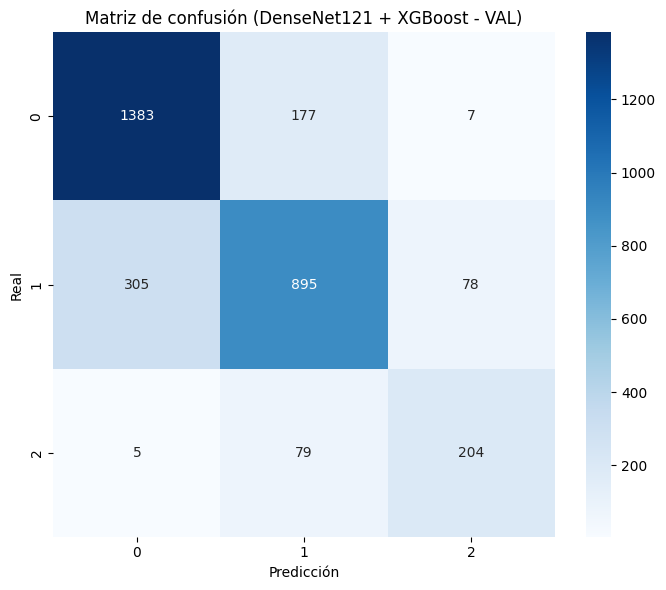

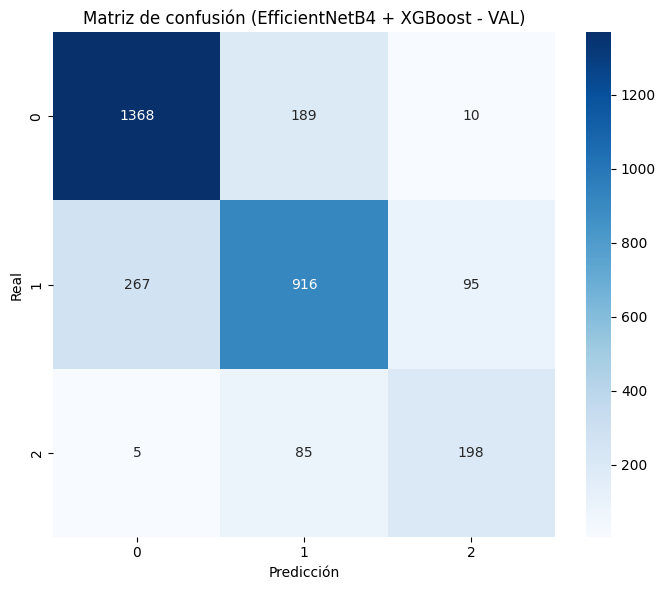

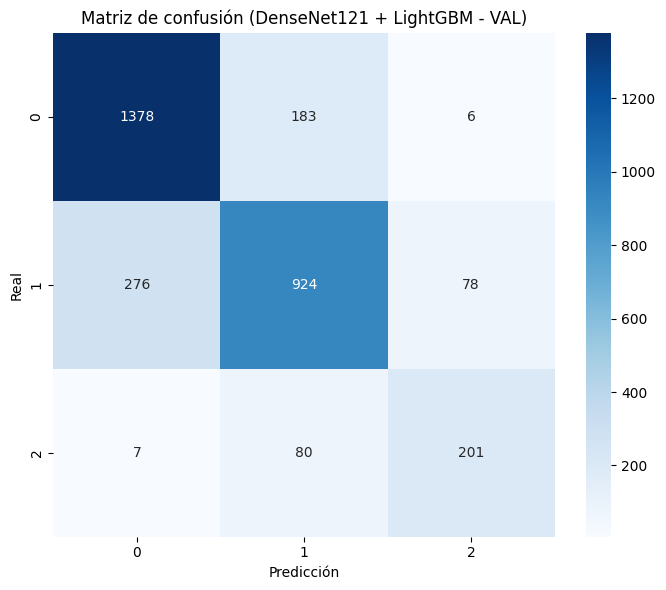

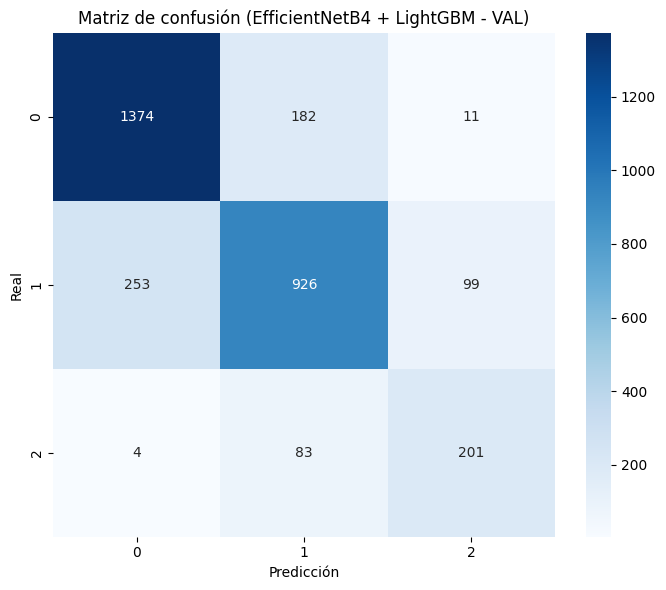

In [34]:
# Matrices de confusión para los 4 candidatos
for candidate_name, res in all_candidate_results.items():
    exp_name = str(res["experiment"])
    y_val_local = feature_sets[exp_name]["y_val"]
    y_pred_local = res["y_val_pred"]

    labels_sorted = sorted(int(x) for x in np.unique(y_val_local))
    cm = confusion_matrix(y_val_local, y_pred_local, labels=labels_sorted)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels_sorted,
        yticklabels=labels_sorted,
    )
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de confusión ({candidate_name} - VAL)")
    plt.tight_layout()
    plt.show()

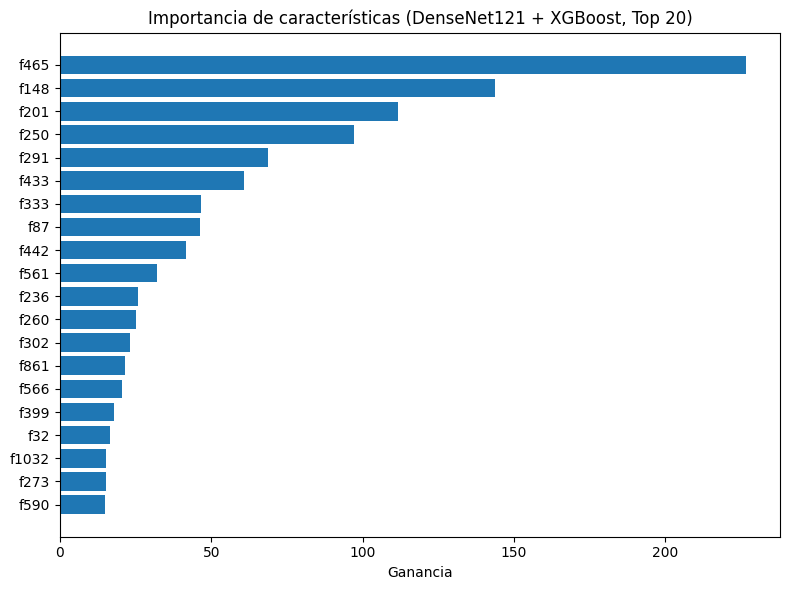

Top características por ganancia (DenseNet121 + XGBoost):


,feature,gain
0,f465,226.513397
1,f148,143.568314
2,f201,111.739937
3,f250,97.103973
4,f291,68.731155
5,f433,60.715206
6,f333,46.661766
7,f87,46.308243
8,f442,41.759533
9,f561,32.125053


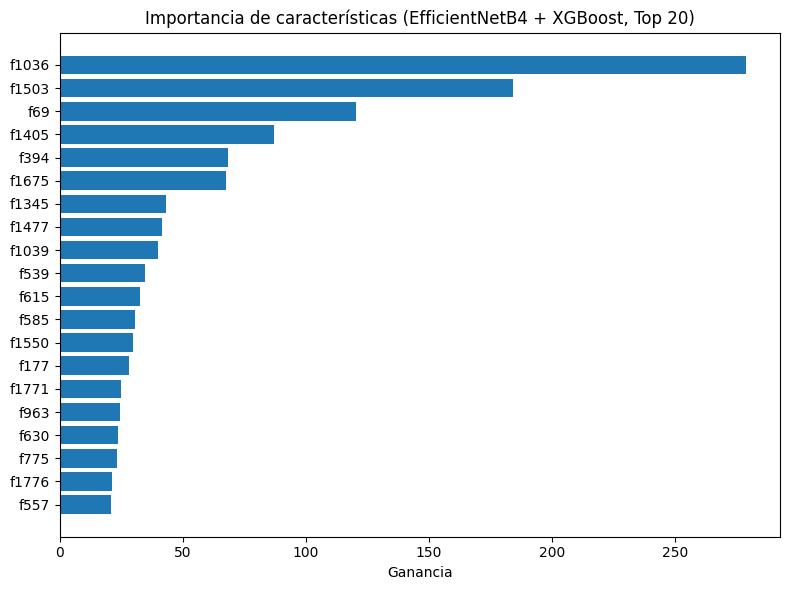

Top características por ganancia (EfficientNetB4 + XGBoost):


,feature,gain
0,f1036,278.682831
1,f1503,184.235748
2,f69,120.387711
3,f1405,86.903854
4,f394,68.196091
5,f1675,67.559998
6,f1345,43.021954
7,f1477,41.369049
8,f1039,39.793648
9,f539,34.533375


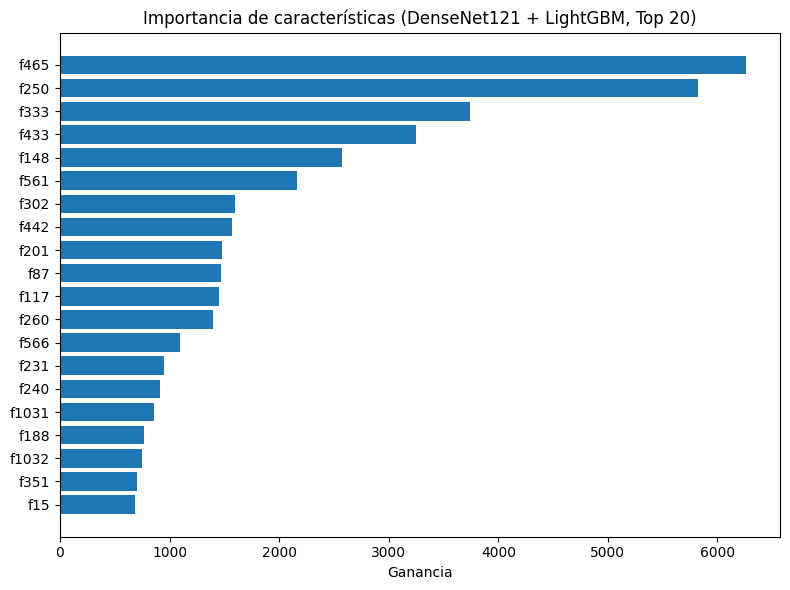

Top características por ganancia (DenseNet121 + LightGBM):


,feature,gain
0,f465,6257.589384
1,f250,5821.668243
2,f333,3741.089360
3,f433,3247.823633
4,f148,2576.956844
5,f561,2160.731983
6,f302,1594.899666
7,f442,1568.474226
8,f201,1478.131938
9,f87,1466.629390


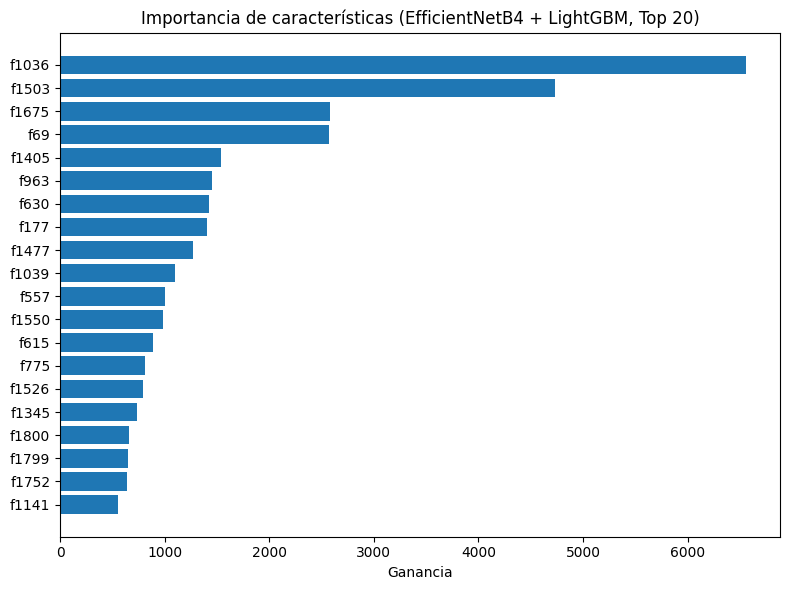

Top características por ganancia (EfficientNetB4 + LightGBM):


,feature,gain
0,f1036,6556.048293
1,f1503,4737.102347
2,f1675,2580.707118
3,f69,2566.896062
4,f1405,1536.406597
5,f963,1453.290997
6,f630,1420.482728
7,f177,1401.103407
8,f1477,1269.137253
9,f1039,1101.796620


In [35]:
# Importancia de características para ambos algoritmos (XGBoost / LightGBM)
for candidate_name, res in all_candidate_results.items():
    model = res["best_model"]
    algo = str(res["algorithm"])

    if algo == "XGBoost":
        score = model.get_booster().get_score(importance_type="gain")
        importance_df = pd.DataFrame(
            {
                "feature": list(score.keys()),
                "gain": list(score.values()),
            }
        )
    else:
        gain = model.booster_.feature_importance(importance_type="gain")
        importance_df = pd.DataFrame(
            {
                "feature": [f"f{i}" for i in range(len(gain))],
                "gain": gain,
            }
        )

    importance_df = (
        importance_df.sort_values("gain", ascending=False)
        .reset_index(drop=True)
    )

    top_k = 20
    top_df = importance_df.head(top_k)

    plt.figure(figsize=(8, 6))
    plt.barh(top_df["feature"][::-1], top_df["gain"][::-1])
    plt.xlabel("Ganancia")
    plt.title(f"Importancia de características ({candidate_name}, Top {top_k})")
    plt.tight_layout()
    plt.show()

    print(f"Top características por ganancia ({candidate_name}):")
    display(top_df)

### Nota de cierre (4 candidatos)

Con esta extensión, el notebook compara explícitamente 4 combinaciones:

1. DenseNet121 + XGBoost
2. EfficientNetB4 + XGBoost
3. DenseNet121 + LightGBM
4. EfficientNetB4 + LightGBM

La selección de `final_model` queda determinada por el mejor **macro-F1 en validación** entre estas cuatro opciones.